# TWS Interpolated Map

## How to run?

1. **Create a Virtual Environment**:
   ```bash
   python -m venv myenv
   ```

2. **Activate the Virtual Environment**:
   ```bash
   source myenv/bin/activate
   ```

3. **Install Required Packages**:
   ```bash
   pip install jupyter numpy matplotlib scipy cartopy
   ```

4. **Start Jupyter Notebook**:
   ```bash
   jupyter notebook
   ```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Step 1: Load the data from the text files

In [2]:
latitudes = np.loadtxt('data/latitudes.txt')
longitudes = np.loadtxt('data/longitudes.txt')
trends = np.loadtxt('data/trends.txt')

# Step 2: Prepare the interpolation grid
Define a grid covering the range of latitudes and longitudes

In [3]:
lat_grid = np.linspace(latitudes.min(), latitudes.max(), 100)
lon_grid = np.linspace(longitudes.min(), longitudes.max(), 100)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

# Step 3: Interpolate the trend data onto the grid
Interpolate using 'linear', 'nearest', or 'cubic' method

In [4]:
trend_grid = griddata((latitudes, longitudes), trends, (lat_grid, lon_grid), method='cubic')

# Step 4: Plot the result

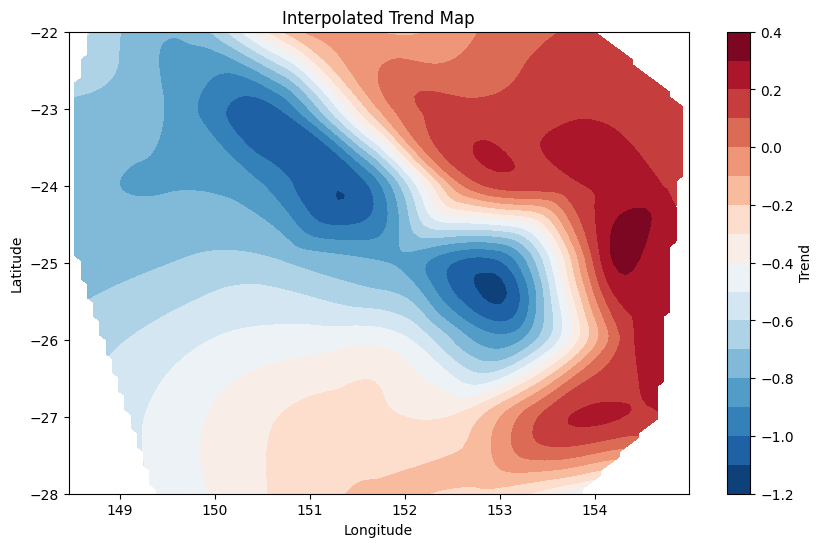

In [12]:
plt.figure(figsize=(10, 6))
plt.contourf(lon_grid, lat_grid, trend_grid, levels=15, cmap='RdBu_r')
plt.colorbar(label='Trend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Trend Map')
plt.show()

# Load the polygon data (Burnett region)


In [6]:
from matplotlib.path import Path

In [7]:
burnett_latitudes = np.loadtxt('data/burnett_latitudes.txt')
burnett_longitudes = np.loadtxt('data/burnett_longitudes.txt')
# Combine the lat/lon of the polygon into an array of points
polygon_points = np.vstack((burnett_longitudes, burnett_latitudes)).T

In [8]:
# Create a mask from the polygon
polygon_path = Path(polygon_points)

In [9]:
# Create a grid of points for the interpolated data
grid_points = np.vstack((lon_grid.ravel(), lat_grid.ravel())).T

In [10]:
# Check which points are inside the polygon
inside_polygon = polygon_path.contains_points(grid_points)

In [11]:
# Reshape the mask to the grid shape
mask = inside_polygon.reshape(lat_grid.shape)

In [12]:
# Apply the mask to the interpolated data
trend_grid_masked = np.ma.masked_where(~mask, trend_grid)

# Plot with Cartopy focusing on the extent of the data

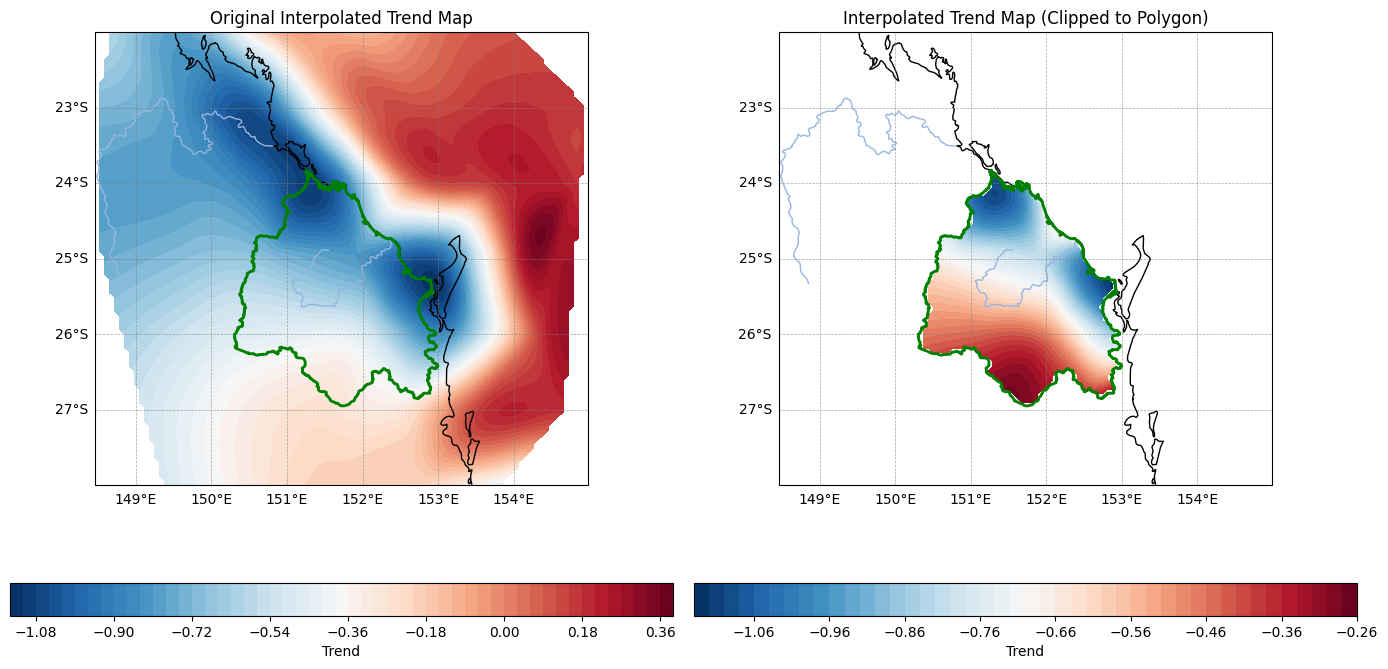

In [22]:
projection = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': projection})

# Automatically calculate the extent based on the data
data_extent = [longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()]

# Function to plot gridlines and the polygon
def add_gridlines_and_polygon(ax, polygon_points):
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    
    # Plot polygon contour in green
    ax.plot(burnett_longitudes, burnett_latitudes, color='green', linewidth=2, transform=ccrs.PlateCarree())

# Increase the number of contour levels for a smoother map
levels = 50  # Increased from 15 to 50 for smoother gradients

# Plot 1: Original Interpolated Map
ax[0].set_extent(data_extent, crs=ccrs.PlateCarree())
ax[0].add_feature(cfeature.COASTLINE)
ax[0].add_feature(cfeature.RIVERS)
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
contourf_0 = ax[0].contourf(lon_grid, lat_grid, trend_grid, levels=levels, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax[0].set_title('Original Interpolated Trend Map')
add_gridlines_and_polygon(ax[0], polygon_points)

# Plot 2: Clipped Map
ax[1].set_extent(data_extent, crs=ccrs.PlateCarree())
ax[1].add_feature(cfeature.COASTLINE)
ax[1].add_feature(cfeature.RIVERS)
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
contourf_1 = ax[1].contourf(lon_grid, lat_grid, trend_grid_masked, levels=levels, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax[1].set_title('Interpolated Trend Map (Clipped to Polygon)')
add_gridlines_and_polygon(ax[1], polygon_points)

# Add colorbars
fig.colorbar(contourf_0, ax=ax[0], orientation='horizontal', label='Trend')
fig.colorbar(contourf_1, ax=ax[1], orientation='horizontal', label='Trend')

plt.tight_layout()
plt.savefig("Smooth.png")
plt.show()